# Modelos epidemiológicos, caso SEIR 
## Authors
- [Guillermo](https://github.com/memoherreraacosta)
- [Daniela](https://github.com/Guemez)


## Time-Dependent Variables
* Here’s an updated list of the variables we currently use:
- N: total population
- S(t): number of people susceptible on day t
- E(t): number of people exposed on day t
- I(t): number of people infected on day t
- R(t): number of people recovered on day t
- D(t): number of people dead on day t

- β: expected amount of people an infected person infects per day
- D: number of days an infected person has and can spread the disease
- γ: the proportion of infected recovering per day (γ = 1/D)
- R₀: the total number of people an infected person infects (R₀ = β / γ)
- δ: length of incubation period
- α: fatality rate
- ρ: rate at which people die (= 1/days from infected until death)

In [128]:
# Imports
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
N = 6220145
# total population ZMG
# Source: https://www.jalisco.gob.mx/es/jalisco/guadalajara
# In 2015, total population was 4'434,878 people
# The growth rate has been creasing by 7%
# Following that rate, by 2020 the total population is
# ZMG population by 2020: 6'220,145

D = 10
# number of days an infected person has and can spread the disease
# Source: World Health Organization
# https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200402-sitrep-73-covid-19.pdf?sfvrsn=5ae25bc7_4#:~:text=The%20incubation%20period%20for%20COVID,occur%20before%20symptom%20onset.
# "The incubation period for COVID-19, which is the time between exposure to the virus (becoming infected) and
# symptom onset, is on average 5-6 days, however can be up to 14 days."
#
# Taking as consideration of time when a person realize that has the virus
# and put his/her self in quarentine, we've decided the average between
# average and worst case 6 and 14 days.


gamma = 1.0 / D
# proportion of infected recovering per day

n = 6
delta = 1.0 / n 
# incubation period of n days
# taking as average of incubation time, we've decided 6 days


R_0 = 1.2
# total number of people an infected person infects
# based on Study of 
#    - SoCieDat
#    - ZapopanLab
#    - Data Science Monterrey
#    - Datlab Community
# Taking the average they give between .8 and 1.5 of range.
# Source: https://datoscovid.mx/

def beta(t):
    return R_0 * gamma
# expected amount of people an infected person infects per day

casos_zmg = {
    "confirmados": 1238,
    "sospechosos": 462,
    "descartados": 9037,
    "defunciones": 116
}
casos_total = sum(casos_zmg.values())
alpha = casos_zmg["defunciones"]/casos_total
# death rate
# Source: https://ssj.jalisco.gob.mx/prensa/noticia/9037
# Date: May 25 (latest)

days = 11
rho = 1/days
# days from infection until death
# source: South Corea editorial Dong-A Ilbo's research

In [179]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    #ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    if L:
        plt.title("Lockdown after {} days".format(L))
        
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
  
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')
        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            print("Yeah")
            ax.spines[spine].set_visible(False)   
    plt.show();

## Lockdown approach, R0 dependent

In [180]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [188]:
L = 100
# Lockdown days

def R_0(t):
    return 6.0 if t < L else 1.2


def beta(t):
    return R_0(t) * gamma


S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
from pprint import pprint
pprint(D[99])

6.1183006050812265


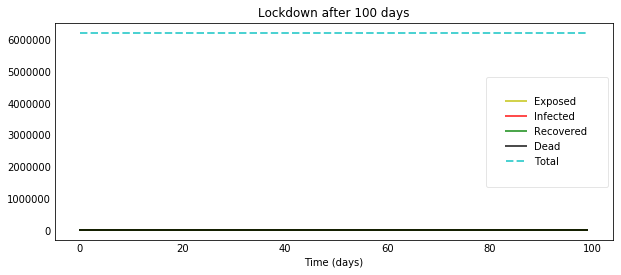

In [186]:
plotseird(t, S, E, I, R, D, L)